In [2]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import os
import math

from scipy import signal
import matplotlib.patches as patches

### Read image

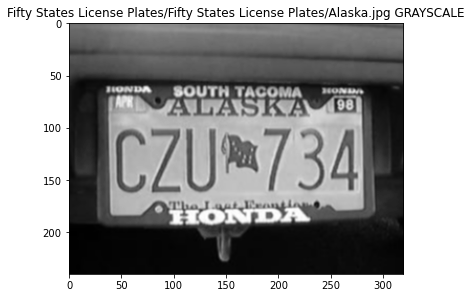

In [14]:
fn = 'Fifty States License Plates/Fifty States License Plates/Alaska.jpg'

im = io.imread(fn)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255.0
im = cv2.GaussianBlur(im,(3,3),0)
fig = plt.figure(figsize=(6,6))
plt.gray()
plt.title(fn+" GRAYSCALE")
ax = plt.subplot(111)
ax.imshow(im)

plt.show()

#### Binarize

In [4]:
def normalize(im_in):
    im_out = (im_in - np.min(im_in)) /(np.max(im_in) - np.min(im_in)) * 1.0
    return im_out

def threshold(im, th):
    ret, thresh = cv2.threshold(im,th,1.0,cv2.THRESH_BINARY)
    return thresh

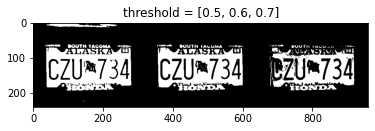

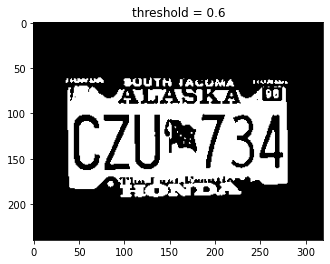

In [5]:
ths = [0.5, 0.6, 0.7]

plt.title(f'threshold = {ths}')
ax = plt.gca()
ax.imshow(np.hstack([threshold(im, x) for x in ths]))
plt.show()

th = 0.6
thresh = threshold(im, th)

plt.title(f'threshold = {th}')
ax = plt.gca()
ax.imshow(thresh)
plt.show()

#### Trim off zeros

In [6]:
def trim(im):
    im = im[~np.all(im == 0, axis=1)]
    trimmed = im[:,~np.all(im == 0, axis=0)]
    return trimmed

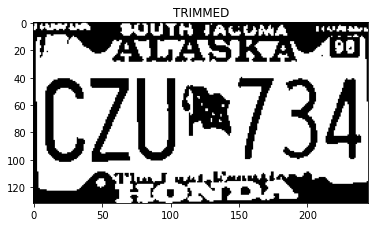

In [7]:
trimmed = trim(thresh)
# io.imsave("plate.png", trimmed.astype('float32'))
plt.title('TRIMMED')
ax = plt.gca()
ax.imshow(trimmed)
plt.show()

### Active contour segment of characters (in snake.py)

In [8]:
def createRect(r, c, w, h, n):
    nw = n*w//(w+h)//2
    nh = n//2 - nw
    rows = np.round(np.linspace(r-h, r+h, nh))
    cols = np.round(np.linspace(c-w, c+w, nw))
    rect = []
    for col in cols:
        rect.append([rows[0], col])
    for row in rows:
        rect.append([row, cols[-1]])
    for col in cols[::-1]:
        rect.append([rows[-1], col])
    for row in rows[::-1]:
        rect.append([row, cols[0]])
    rect = np.array(rect)

    return rect.astype(int)
    

def normalize(im_in):
    im_out = ((im_in - np.min(im_in)) * (1/(np.max(im_in) - np.min(im_in)) * 255))
    return im_out


def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


def avgDistance(snake):
    d = 0
    for i, pt_i in enumerate(snake):
        d += distance(pt_i, snake[(i+1)%len(snake)])
    d /= len(snake)
    return d


def eCont(snake, d, id, pi):
    id_before = (id-1+len(snake)) % len(snake)
    pi_1 = snake[id_before]
    return (d - distance(pi_1, pi))**2


def eCurve(snake, id, pi):
    id_before = (id-1+len(snake)) % len(snake)
    id_after = (id+1) % len(snake)
    pi_before = snake[id_before]
    pi_after = snake[id_after]
    return (pi_before[0]+pi_after[0]-2*pi[0])**2+(pi_before[1]+pi_after[1]-2*pi[1])**2


def eImage(im, snake):
    filterX = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    filterY = np.array([[0,-1,0],[0,0,0],[0,1,0]])
    dX = signal.convolve2d(im, filterX, boundary='symm', mode='same')
    dY = signal.convolve2d(im, filterY, boundary='symm', mode='same')
    return -np.sqrt(np.power(dX, 2)+np.power(dY, 2))


def activeContourLoop(im, snake, grad_mag, weights):
    neighborhood = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]]
    d = avgDistance(snake)
    stop = True
    for i, pi in enumerate(snake):
        min_energy, min_pi = float('inf'), pi
        for dPos in neighborhood:
            new_pi = pi+dPos
            if new_pi[0] < 0 or new_pi[0] >= len(im) or new_pi[1] < 0 or new_pi[1] >= len(im[0]):
                continue
            energy = np.array([eCont(snake, d, i, new_pi), eCurve(snake, i, new_pi), grad_mag[tuple(new_pi)]])
            sum_energy = np.sum(energy * weights)
            if sum_energy < min_energy:
                min_energy = sum_energy
                min_pi = new_pi
        if any(min_pi != pi):
            stop = False
        snake[i] = min_pi
    return stop


def activeContour(im, init, weights, iterations=-1):
    snake = np.copy(init)
    grad_mag = eImage(im, snake)
    if iterations > 0:
        for _ in range(iterations):
            activeContourLoop(im, snake, grad_mag, weights)
    else:
        stop = False
        while not stop:
            stop = activeContourLoop(im, snake, grad_mag, weights)
    return snake

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


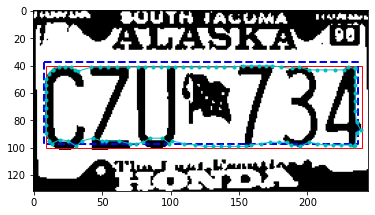

In [9]:
im_snake = trimmed
weights = [0.1,0.1,1000]

rows, cols = im_snake.shape[0], im_snake.shape[1]

center_x, center_y = rows//1.95, cols//2
h, w = round(0.46*rows/2), round(0.94*cols/2)

im_denoised = cv2.GaussianBlur(im_snake, (3,3), 0)

init = createRect(center_x, center_y, w, h, 100)
snake = activeContour(im_denoised, init[:-1,:], weights, iterations=3000) # Passing int[:-1,:] to avoid disconnection
snake = np.append(snake, [snake[0]], axis=0) # Append first point to the rear of snake

# rectangle patch area
begin = np.min(snake, axis=0)
end = np.max(snake, axis=0)
height, width = end[0]-begin[0]+1, end[1]-begin[1]+1
rect = patches.Rectangle((begin[1], begin[0]), width, height, linewidth=1, edgecolor='r', facecolor='none')

io.imsave("plate_crop.png", im_snake[begin[0]:end[0],begin[1]:end[1]])

fig = plt.figure(figsize=(6,6))
plt.gray()
# plt.title(f'{pts[param]} points. α={weights[0]}, β={weights[1]}, γ={weights[2]}. 2000 iterations')
ax = plt.subplot(111)
ax.imshow(im_snake)
ax.plot(init[:,1], init[:,0], '--b', lw=2)
ax.plot(snake[:,1], snake[:,0], '-c.', lw=1)
ax.add_patch(rect)
plt.show()

### Projection

<ipython-input-10-c8554a3393f3>:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  crop = rgb2gray(io.imread('plate_crop.png')) * (1.0/255)


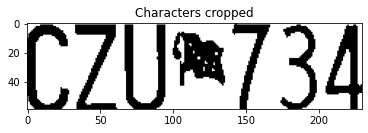

In [10]:

crop = rgb2gray(io.imread('plate_crop.png')) * (1.0/255)
plt.title('Characters cropped')
ax = plt.gca()
ax.imshow(crop)
plt.show()

#### Segment single characters by vertical projection

7


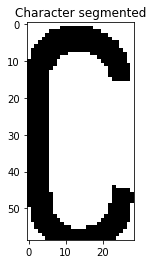

In [11]:
# Projection
char_flags = ~np.all(crop > 0, axis=0)
inner, start = False, -1
chars = []
for i, f in enumerate(char_flags):
    if f and not inner:
        inner = True
        start = i
    elif inner and not f:
        inner = False
        chars.append(crop[:,start:i])
if inner:
    chars.append(crop[:,start:])
print(len(chars))

plt.title('Character segmented')
ax = plt.gca()
ax.imshow(chars[0])
plt.show()

#### Save images

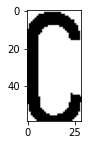

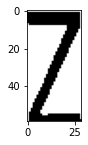

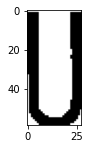

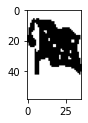

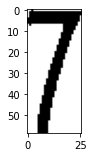

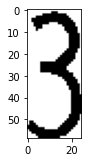

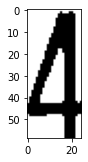

In [12]:
for i in range(len(chars)):
    # io.imsave(f"{i}.png", chars[i])
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(1, len(chars), i+1)
    # ax.set_title(class_names[preds[j]])
    # ax.axis('off')
    ax.imshow(chars[i])

### OCR (under path "./ocr/")